In [106]:
!pip install catboost

     |████████████████████████████████| 63.6MB 19.3MB/s eta 0:00:01
     |████████████████████████████████| 7.3MB 9.9MB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-cp36-none-any.whl size=11432 sha256=0bfcf61c80f8623bf1d38261df2a0803dee2f44960530e747ee1e677a7f6e5ba
  Stored in directory: /home/dasein/.cache/pip/wheels/d7/a9/33/acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying
You should consider upgrading via the 'pip install --upgrade pip' command.


# Import libraries

In [1]:
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import  torch
import seaborn as sns

from scipy.stats import skew
from scipy.stats import kurtosis
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

import eli5
from eli5.sklearn import PermutationImportance
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import graphviz

# 1- Exploratory Data Analysis(EDA)

### 1.1 DATA IMPORT

In [2]:
%%time
train_df = pd.read_csv('train.csv', dtype={'acoustic_data' : np.int16, 'time_to_failure':np.float32})

CPU times: user 59.8 s, sys: 3.66 s, total: 1min 3s
Wall time: 1min 6s


In [3]:
print("Train: rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))

Train: rows:629145480 cols:2


In [4]:
train_df.head(10)


,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629145480 entries, 0 to 629145479
Data columns (total 2 columns):
acoustic_data      int16
time_to_failure    float32
dtypes: float32(1), int16(1)
memory usage: 3.5 GB


In [6]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
submission.head()

,time_to_failure
seg_id,
seg_00030f,0
seg_0012b5,0
seg_00184e,0
seg_003339,0
seg_0042cc,0


In [7]:
print("submission has: rows:{} cols:{}".format(submission.shape[0], submission.shape[1]))

submission has: rows:2624 cols:1


### 1.2 Visualization

In [8]:
mini_train_df=pd.read_csv("train.csv",nrows=150000)

In [9]:
mini_train_df.describe()

,acoustic_data,time_to_failure
count,150000.000000,150000.000000
mean,4.884113,1.450182
std,5.101106,0.011248
min,-98.000000,1.430797
25%,3.000000,1.440398
50%,5.000000,1.449999
75%,7.000000,1.459599
max,104.000000,1.469100


In [10]:
mini_train_df.isna().sum()

acoustic_data      0
time_to_failure    0
dtype: int64

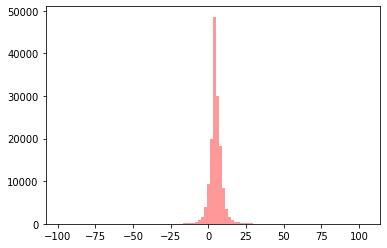

In [11]:
sns.distplot(mini_train_df.acoustic_data.values, color="Red", bins=100, kde=False)

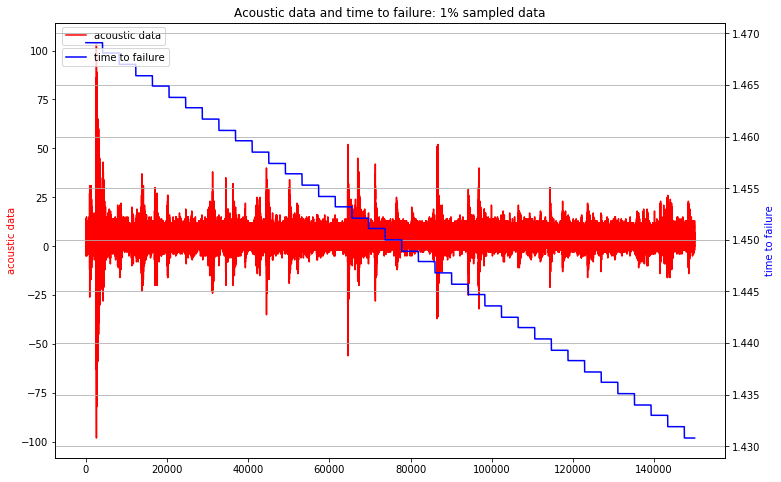

In [12]:
def initial_viusal_plot(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)
initial_viusal_plot(mini_train_df['acoustic_data'], mini_train_df['time_to_failure'])

### 1.3 Data Preprocessing

In [13]:
# Here we take 150,000 rows since data is too large
rows=150000
data_segment=int(np.floor(train_df.shape[0]/rows))
data_segment

4194

In [14]:
X_train = pd.DataFrame(index=range(data_segment), dtype=np.float64,
                       columns=['ave', 'std', 'max', 'min','sum','skew','kurt'])
y_train = pd.DataFrame(index=range(data_segment), dtype=np.float64,
                       columns=['time_to_failure'])

In [15]:
y_train.head()

,time_to_failure
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [16]:
X_train.head()

,ave,std,max,min,sum,skew,kurt
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 1.3.1 Creating features using stastical attributes

In [17]:
%%time

for segment in tqdm(range(data_segment)):
    seg=train_df.iloc[segment*rows:segment*rows+rows] #selecting last 150,000 rows from train segment form train_df
    x=seg['acoustic_data'].values
    y=seg['time_to_failure'].values[-1]
    
    y_train.loc[segment, 'time_to_failure'] = y
    X_train.loc[segment, 'ave'] = x.mean()
    X_train.loc[segment, 'std'] = x.std()
    X_train.loc[segment, 'max'] = x.max()
    X_train.loc[segment, 'min'] = x.min()
    X_train.loc[segment, 'sum'] = x.sum()
    X_train.loc[segment, 'skew'] =skew(x)
    X_train.loc[segment, 'kurt'] = kurtosis(x)

100%|██████████| 4194/4194 [00:18<00:00, 226.35it/s]

CPU times: user 18.6 s, sys: 32.1 ms, total: 18.6 s
Wall time: 18.5 s


In [18]:
pd.options.display.float_format = '{:.6f}'.format

In [19]:
X_train.head()

,ave,std,max,min,sum,skew,kurt
0,4.884113,5.101089,104.000000,-98.000000,732617.000000,-0.024061,33.661319
1,4.725767,6.588802,181.000000,-154.000000,708865.000000,0.390557,98.755185
2,4.906393,6.967374,140.000000,-106.000000,735959.000000,0.217388,33.554053
3,4.902240,6.922282,197.000000,-199.000000,735336.000000,0.757270,116.544247
4,4.908720,7.301086,145.000000,-126.000000,736308.000000,0.064530,52.976099


In [20]:
y_train.head()

,time_to_failure
0,1.430797
1,1.391499
2,1.353196
3,1.313798
4,1.274400


--> check for missing data

In [21]:
def check_missing_data(df):
    flag=df.isnull().sum().any()
    if flag==True:
        total= df.isnull().sum()
        percent=(df.isnull().sum())/(df.isnull().count()*100)
        output=pd.concat([total,percent], axis=1, keys=['Total','Percent'])
        data_type=[]
        
        for col in df.columns:
            dtype = str(df[col].dtype)
            data_type.append(dtype)
        output['Types'] = data_type
        return(np.transpose(output))
    else:
        return(False)

In [22]:
check_missing_data(X_train)

False

In [23]:
X_test= pd.DataFrame(columns=X_train.columns, dtype=np.float64, index=submission.index)

In [24]:
X_test.head()

,ave,std,max,min,sum,skew,kurt
seg_id,,,,,,,
seg_00030f,nan,nan,nan,nan,nan,nan,nan
seg_0012b5,nan,nan,nan,nan,nan,nan,nan
seg_00184e,nan,nan,nan,nan,nan,nan,nan
seg_003339,nan,nan,nan,nan,nan,nan,nan
seg_0042cc,nan,nan,nan,nan,nan,nan,nan


In [25]:
%%time
for seg_id in  tqdm(X_test.index):
    seg = pd.read_csv('test/' + seg_id + '.csv')
    
    x = seg['acoustic_data'].values
    
    X_test.loc[seg_id, 'ave'] = x.mean()
    X_test.loc[seg_id, 'std'] = x.std()
    X_test.loc[seg_id, 'max'] = x.max()
    X_test.loc[seg_id, 'min'] = x.min()
    X_test.loc[seg_id, 'sum'] = x.sum()
    X_test.loc[seg_id, 'skew'] =skew(x)
    X_test.loc[seg_id, 'kurt'] = kurtosis(x)

100%|██████████| 2624/2624 [00:30<00:00, 86.40it/s]

CPU times: user 29.5 s, sys: 348 ms, total: 29.9 s
Wall time: 30.4 s


In [121]:
X_test.shape

(2624, 7)

In [122]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

In [123]:
X_test_scaled = scaler.transform(X_test)

In [124]:
X=X_train.copy()
y=y_train.copy()

## Feature Enginerring

In [78]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)

In [79]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = train_X.columns.values

eli5 provides a way to compute feature importances for any black-box estimator by measuring how score decreases when a feature is not available; the method is also known as “permutation importance” or “Mean Decrease Accuracy (MDA)”.


To avoid re-training the estimator we can remove a feature only from the test part of the dataset, and compute score without using this feature. It doesn’t work as-is, because estimators expect feature to be present. So instead of removing a feature we can replace it with random noise - feature column is still there, but it no longer contains useful information. This method works if noise is drawn from the same distribution as original feature values (as otherwise estimator may fail). The simplest way to get such noise is to shuffle values for a feature, i.e. use other examples’ feature values - this is how permutation importance is computed.

https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html

https://towardsdatascience.com/the-mathematics-of-decision-trees-random-forest-and-feature-importance-in-scikit-learn-and-spark-f2861df67e3

In [80]:
rfc_model = RandomForestRegressor(random_state=0).fit(train_X, train_y.values.ravel())

In [81]:
perm = PermutationImportance(rfc_model, random_state=1).fit(val_X, val_y)

In [82]:
eli5.show_weights(perm, feature_names = val_X.columns.tolist(), top=7)

Weight,Feature
0.7040 ± 0.0950,std
0.2536 ± 0.0215,kurt
0.0607 ± 0.0137,min
0.0151 ± 0.0174,max
0.0107 ± 0.0150,skew
0.0058 ± 0.0116,sum
-0.0008 ± 0.0080,ave


Feature imortance using sklearn

# Partial Dependence Plots

In [83]:
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
tree_model = DecisionTreeRegressor(random_state=0, max_depth=5, min_samples_split=5).fit(train_X, train_y)

In [84]:
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=X.columns)

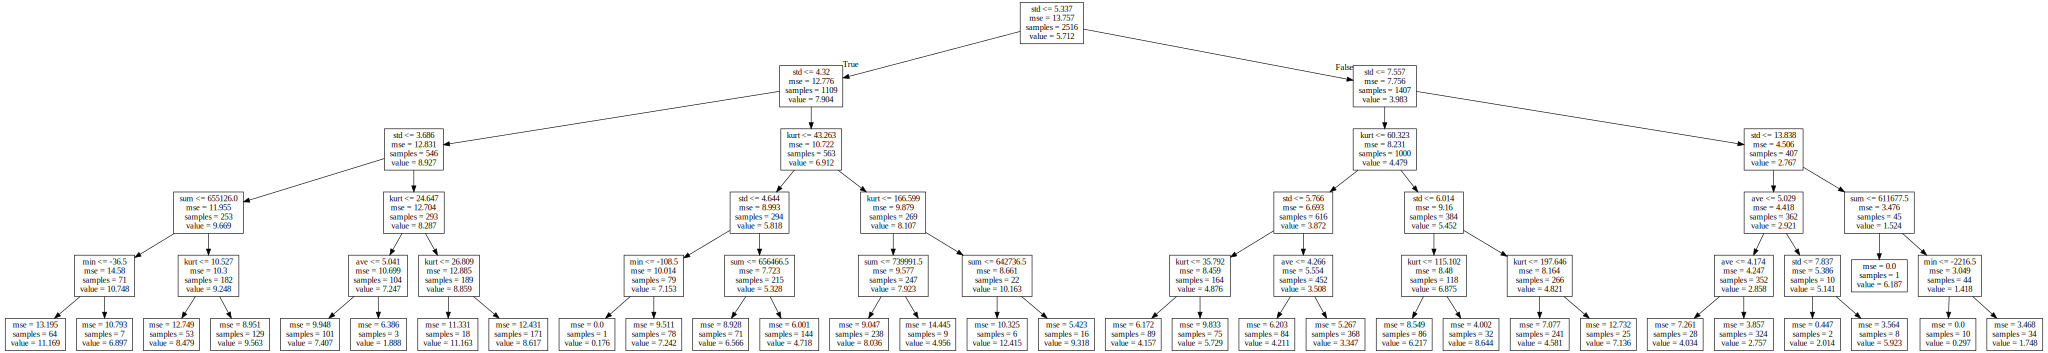

In [85]:
graphviz.Source(tree_graph)

# SHAP Values

In [86]:
import shap

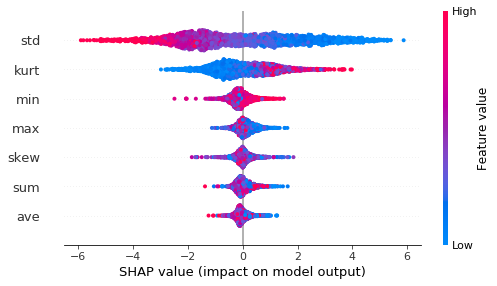

In [87]:

shap_values = shap.TreeExplainer(rfc_model).shap_values(train_X)
shap.summary_plot(shap_values, train_X)

In [88]:
row_to_show = 5
data_for_prediction = val_X.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)
print(data_for_prediction)
print(data_for_prediction_array)

ave         4.630913
std         3.176717
max        47.000000
min       -40.000000
sum    694637.000000
skew       -0.097069
kurt        7.984381
Name: 3094, dtype: float64
[[ 4.63091333e+00  3.17671660e+00  4.70000000e+01 -4.00000000e+01
   6.94637000e+05 -9.70687305e-02  7.98438129e+00]]


In [89]:
tree_model.predict(data_for_prediction_array);

In [90]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(tree_model)

# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction)

In [91]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction)

# pdpbox

In [92]:
from pdpbox import pdp, get_dataset, info_plots

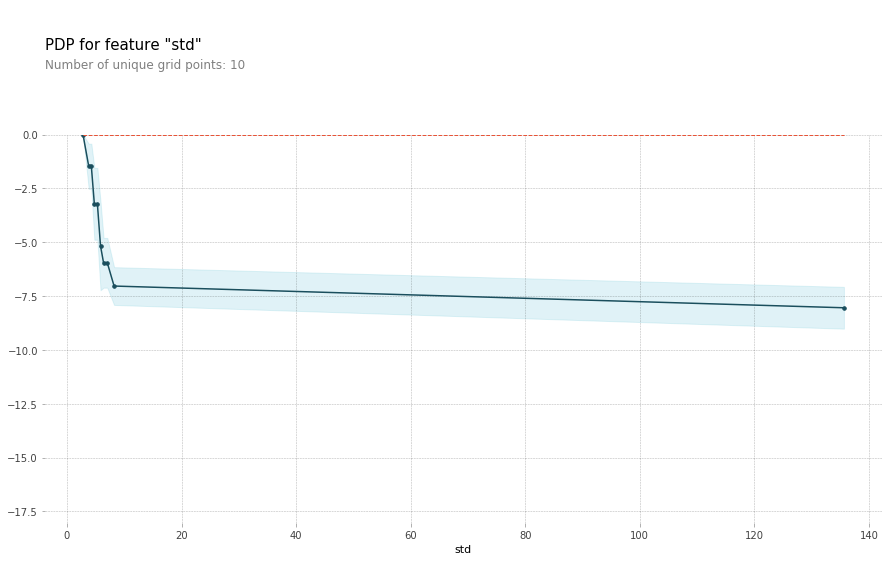

In [93]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=tree_model, dataset=val_X, model_features=X.columns, feature='std')

# plot it
pdp.pdp_plot(pdp_goals, 'std')
plt.show()

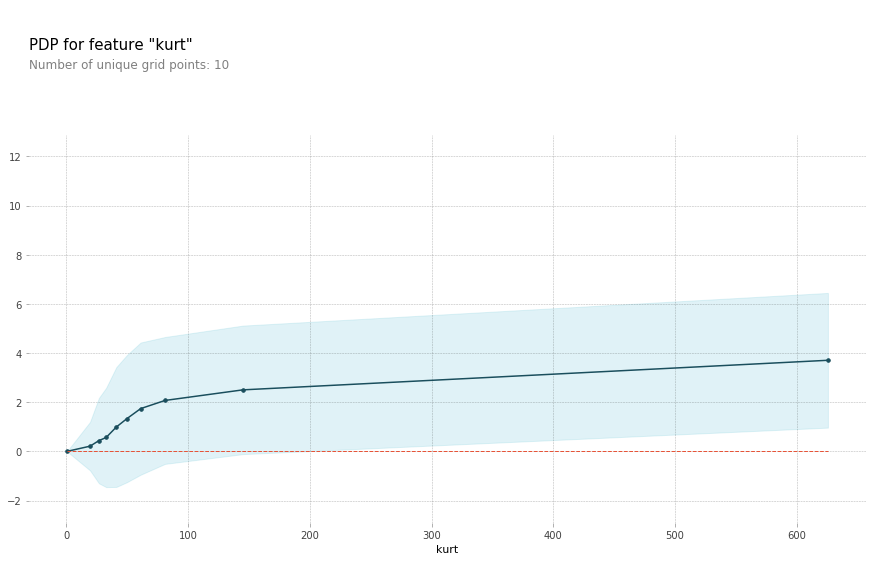

In [94]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=rfc_model, dataset=val_X, model_features=X.columns, feature='kurt')

# plot it
pdp.pdp_plot(pdp_goals, 'kurt')
plt.show()

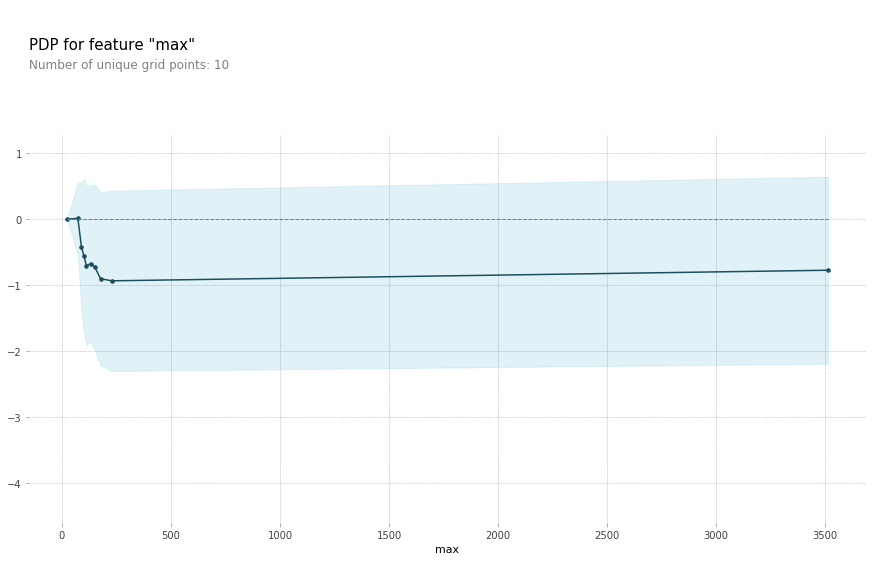

In [95]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=rfc_model, dataset=val_X, model_features=X.columns, feature='max')

# plot it
pdp.pdp_plot(pdp_goals, 'max')
plt.show()

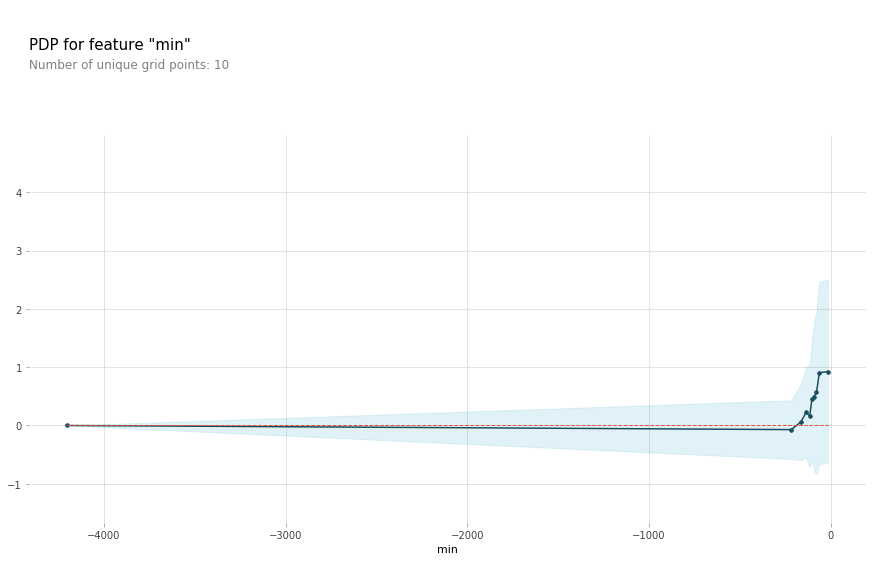

In [96]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=rfc_model, dataset=val_X, model_features=X.columns, feature='min')

# plot it
pdp.pdp_plot(pdp_goals, 'min')
plt.show()

# Models

## 1) SVM 

In [118]:
from sklearn.svm import NuSVR
import time


In [119]:
svm = NuSVR()
svm.fit(X_train_scaled, y_train.values.flatten())
y_pred_svm = svm.predict(X_train_scaled)

In [120]:
score = mean_absolute_error(y_train.values.flatten(), y_pred_svm)
print(f'Score: {score:0.3f}')

Score: 2.305


## 2) LGBM

In [100]:
import lightgbm as lgb

In [101]:
folds = KFold(n_splits=5, shuffle=True, random_state=42)

In [102]:
params = {'objective' : "regression", 
               'boosting':"gbdt",
               'metric':"mae",
               'boost_from_average':"false",
               'num_threads':8,
               'learning_rate' : 0.001,
               'num_leaves' : 52,
               'max_depth':-1,
               'tree_learner' : "serial",
               'feature_fraction' : 0.85,
               'bagging_freq' : 1,
               'bagging_fraction' : 0.85,
               'min_data_in_leaf' : 10,
               'min_sum_hessian_in_leaf' : 10.0,
               'verbosity' : -1}

In [103]:
%%time

y_pred_lgb = np.zeros(len(X_test_scaled))
for fold_n, (train_index, valid_index) in tqdm(enumerate(folds.split(X))):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
    y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
    model = lgb.LGBMRegressor(**params, n_estimators = 22000, n_jobs = -1)
    model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=1000, early_stopping_rounds=200)
            
    y_pred_valid = model.predict(X_valid)
    y_pred_lgb += model.predict(X_test_scaled, num_iteration=model.best_iteration_) / folds.n_splits

0it [00:00, ?it/s]

Fold 0 started at Tue Dec  3 11:30:39 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's l1: 2.60954	valid_1's l1: 2.84664
[2000]	training's l1: 1.85333	valid_1's l1: 2.29594
[3000]	training's l1: 1.65972	valid_1's l1: 2.25186
Early stopping, best iteration is:
[3134]	training's l1: 1.6423	valid_1's l1: 2.25151


1it [00:03,  3.85s/it]

Fold 1 started at Tue Dec  3 11:30:43 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's l1: 2.63656	valid_1's l1: 2.65808
[2000]	training's l1: 1.88204	valid_1's l1: 2.1707
Early stopping, best iteration is:
[2485]	training's l1: 1.76874	valid_1's l1: 2.15639


2it [00:06,  3.61s/it]

Fold 2 started at Tue Dec  3 11:30:46 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's l1: 2.61834	valid_1's l1: 2.81481
[2000]	training's l1: 1.87075	valid_1's l1: 2.28956
Early stopping, best iteration is:
[2771]	training's l1: 1.70476	valid_1's l1: 2.26785


3it [00:10,  3.58s/it]

Fold 3 started at Tue Dec  3 11:30:49 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's l1: 2.59728	valid_1's l1: 2.86318
[2000]	training's l1: 1.84568	valid_1's l1: 2.35266
Early stopping, best iteration is:
[2611]	training's l1: 1.7104	valid_1's l1: 2.324


4it [00:13,  3.52s/it]

Fold 4 started at Tue Dec  3 11:30:53 2019
Training until validation scores don't improve for 200 rounds
[1000]	training's l1: 2.64302	valid_1's l1: 2.56894
[2000]	training's l1: 1.88604	valid_1's l1: 2.17599
Early stopping, best iteration is:
[2232]	training's l1: 1.82061	valid_1's l1: 2.17338


5it [00:16,  3.34s/it]

CPU times: user 2min 10s, sys: 1.39 s, total: 2min 12s
Wall time: 16.7 s


## 3) Catboost

In [112]:
from catboost import CatBoostRegressor,Pool

In [113]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X=X_train.copy()
y=y_train.copy()

In [133]:
train_pool = Pool(X,y)
cat_model = CatBoostRegressor(
                               iterations=2000,
                               learning_rate=0.03,
                               eval_metric='MAE',
                               loss_function='RMSE',
                              )
cat_model.fit(X,y,silent=True)
y_pred_cat = cat_model.predict(X_test)
print(y_pred_cat)

[ 4.89428843  4.06343236  5.09366155 ...  3.47768004  2.20869615
 10.72998821]
